In [67]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

### 1. download and process data

In [9]:
url  = 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'
data = pd.read_csv(url,sep=',',header=None)
data.columns = ['age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal','DISEASE']

# data contain some ?'s; replace with NaN and drop those rows
data = data.replace('?',np.nan).dropna()

In [16]:
# normalize data for numerical columns
normalCols = data.columns
normalCols = normalCols.drop(['sex','fbs','exang','DISEASE'])
normalCols

Index(['age', 'cp', 'trestbps', 'chol', 'restecg', 'thalach', 'oldpeak',
       'slope', 'ca', 'thal'],
      dtype='object')

In [17]:
for col in normalCols:
    d = pd.to_numeric(data[col]) # force to numeric (addresses some data-format issues)
    data[col] = (d - d.mean())/d.std(ddof=1)

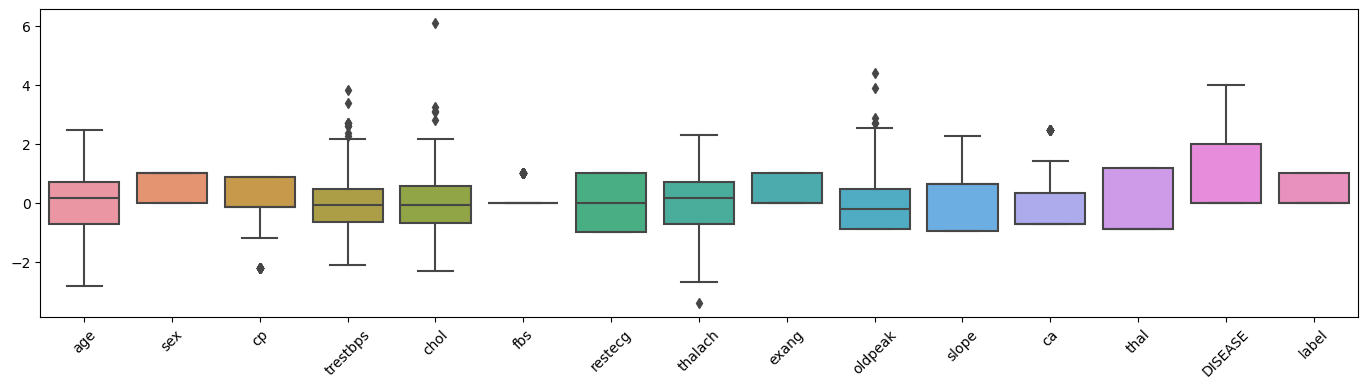

In [68]:
# check the distributions again
fig,ax = plt.subplots(1,figsize=(17,4))
ax = sns.boxplot(data=data)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
plt.show()

In [20]:
data['label'] = np.where(data['DISEASE']>0, 1, 0)

In [25]:
feat_cols = data.columns
feat_cols = feat_cols.drop(['label','DISEASE'])

dataT  = torch.tensor(data[feat_cols].values).float()
labelT = torch.tensor(data['label'].values).float()
labelT = labelT[:,None]

### 2. prepare train and test sets

In [70]:
randseed = 43
X_train,X_test, y_train,y_test = train_test_split(dataT, labelT, test_size=.2, random_state=randseed)

In [78]:
train_data = TensorDataset(X_train, y_train)
test_data  = TensorDataset(X_test, y_test)

batchsize = 16

train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

### 3. create model

In [72]:
def createModel(lr=.001):

    class HDClf(nn.Module):

        def __init__(self):
            super().__init__()

            # input layer
            self.input = nn.Linear(len(feat_cols),32)

            # hidden layer
            self.fc1 = nn.Linear(32, 32)
            self.fc2 = nn.Linear(32, 16)

            # output layer
            self.output = nn.Linear(16, 1)
        
        def forward(self, x):
            x = F.relu( self.input(x) )
            x = F.relu( self.fc1(x) )
            x = F.relu( self.fc2(x) )

            return self.output(x)

    model = HDClf()

    optimizer = torch.optim.Adam(model.parameters(),lr=lr)
    lossfun = nn.BCEWithLogitsLoss() 

    return model, optimizer, lossfun
        

In [73]:
# quick test to make sure the model is functioning
model, _, lossfun = createModel()

X,y = next(iter(train_loader))
yHat = model(X)
print(yHat)

# test the loss function
lossfun(yHat,y)

tensor([[0.1269],
        [0.1691],
        [0.2149],
        [0.1648]], grad_fn=<AddmmBackward0>)


tensor(0.6853, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

In [75]:
def trainModel(model, optimizer, lossfun, numepochs=100):

    # initialize losses and accuracies
    trainLoss = torch.zeros(numepochs)
    testLoss  = torch.zeros(numepochs)
    trainAcc  = torch.zeros(numepochs)
    testAcc   = torch.zeros(numepochs)

    # loop over epochs
    for epochi in range(numepochs):

        # loop over training data batches
        batchAcc  = []
        batchLoss = []
        for X,y in train_loader:

            # forward pass and loss
            yHat = model(X)
            loss = lossfun(yHat,y)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # loss from this batch
            batchLoss.append(loss.item())

            # compute accuracy
            predictions = (torch.sigmoid(yHat)>.5).float()
            batchAcc.append( torch.mean((predictions==y).float()) ) 
        # end of batch loop...

        # train accuracy and loss
        trainAcc[epochi] = torch.tensor(np.mean(batchAcc))

        # and get average losses across the batches
        trainLoss[epochi] = torch.tensor(np.mean(batchLoss))

        # get test prediction
        X,y = next(iter(test_loader))
        with torch.no_grad(): # deactivates autograd
            yHat = model(X)

        # test accuracy and loss
        predictions = (torch.sigmoid(yHat)>.5).float()
        testAcc[epochi] = torch.mean((predictions==y).float())

        loss = lossfun(yHat,y)
        testLoss[epochi] = loss.item()

    return model, trainLoss, testLoss, trainAcc, testAcc

In [83]:
model, optimizer, lossfun = createModel()

model, trainLoss, testLoss, trainAcc, testAcc = trainModel(model, optimizer, lossfun, numepochs=20)

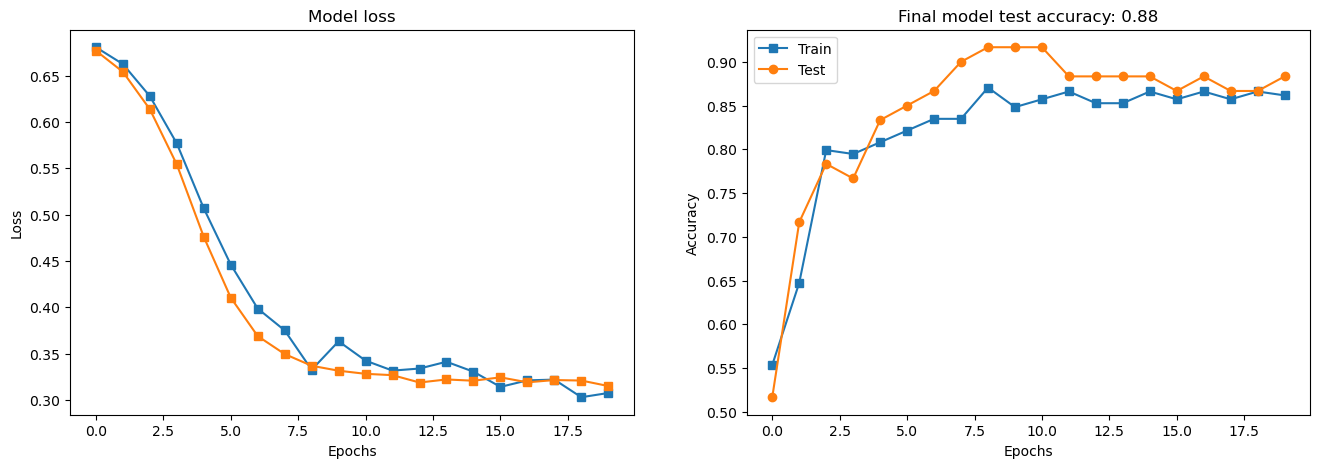

In [84]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainLoss,'s-',label='Train')
ax[0].plot(testLoss,'s-',label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,'s-',label='Train')
ax[1].plot(testAcc,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}')
ax[1].legend()

plt.show()